# Home Credit Group Dataset: Notebook 2/2 - ML Modeling, Tuning and Deployment

### Introduction: 
Home Credit is a financial institution that specializes in providing consumer loans to individuals with limited or no credit history. The company operates in multiple countries and focuses on offering responsible and accessible financial services, particularly to unbanked or underbanked populations. Home Credit leverages non-traditional data sources, such as mobile phone usage and other alternative data, to assess the creditworthiness of applicants.

### Main Motivation:
- We want to help Home Credit to fully automate their decisions and thus save time, resources, and avoid lending money to risky clients.

### Assumptions:
- Dataset contains relevant features to predict customer repayment abilities.
- An ML model can be trained to automate a part of the loan application evaluation process, and thus, save time and resources for Home Credit. 

### Objectives:
- Create a preprocessing Pipeline
- Create baseline models
- Try out various algorithms for classification of the Loan status
- Perform model selection, tune hyperparameters for the best-performing models, and test those models.
- Deploy the Flask app with the best-performing model to Google Cloud Platform.

### Biases:
- The dataset is imbalanced.
- In this project, we're not using all of the available data from previous loan applications and Home Burreau. Those additional features may be important for higher predictive power of the final model.


### Additional Notes:
- The main performance metric for this classification task is ROC-AUC. Additionally, we will check the F2 scores since we want to catch most potentially problematic loans, but also avoid flagging too many good loans and performing too much costly additional assessment. Ideally, this metric should be discussed with the client beforehand.
- Our long-term objective are to increase the revenue of Home Credit organization. We believe that integrating an ML model could reduce the cost of processing loan applications that typically includes various factors such as:

    1. **Personnel Costs:** Costs associated with the salaries and benefits of the staff involved in processing and evaluating loan applications.
    
    2. **Technology and Infrastructure:** Expenses related to the use of technology, software, and infrastructure required for the application review process.
    
    3. **Credit Bureau Fees:** Fees paid to credit bureaus for obtaining credit reports and credit scores of applicants.
    
    4. **Administrative Costs:** General administrative expenses, including office supplies, utilities, and other overhead costs.
    
    5. **Compliance and Regulatory Costs:** Costs associated with ensuring compliance with financial regulations and legal requirements.
    
    6. **Marketing and Advertising:** Costs related to marketing efforts to attract loan applicants.
    
    7. **Training and Development:** Costs associated with training staff on the latest lending practices and compliance requirements.

In [619]:
!python -m black "home_credit_ML.ipynb"

reformatted home_credit_ML.ipynb

All done! ✨ 🍰 ✨
1 file reformatted.


In [614]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV

from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

import shap
import joblib

import helper_functions as hf

import warnings
warnings.filterwarnings("ignore")

In [3]:
application_train_upd_reduced = pd.read_csv("application_train_upd_reduced.csv", index_col=False)
selected_app_train_upd = pd.read_csv("selected_app_train_upd.csv", index_col=False)
application_test_upd_reduced = pd.read_csv("application_test_upd_reduced.csv", index_col=False)
selected_app_test_upd = pd.read_csv("selected_app_test_upd.csv", index_col=False)

application_train_upd_reduced = application_train_upd_reduced.loc[:, ~application_train_upd_reduced.columns.str.contains('^Unnamed')]
selected_app_train_upd = selected_app_train_upd.loc[:, ~selected_app_train_upd.columns.str.contains('^Unnamed')]
application_test_upd_reduced = application_test_upd_reduced.loc[:, ~application_test_upd_reduced.columns.str.contains('^Unnamed')]
selected_app_test_upd = selected_app_test_upd.loc[:, ~selected_app_test_upd.columns.str.contains('^Unnamed')]

application_train_upd_reduced = application_train_upd_reduced.loc[:, ~application_train_upd_reduced.columns.str.contains('BIN')]
selected_app_train_upd = selected_app_train_upd.loc[:, ~selected_app_train_upd.columns.str.contains('BIN')]

# 1. Preprocessing Pipelines

##### Summary:
- Handled the outliers by trimming the lower and upper 10% of outliers based on IQR. This was enough to get rid of the suspicious extreme outliers that were presented in several columns (see the notebook 1/2 for the outlier examination).
- Undersampled the majority class (non-problematic loans) to optimize the ML model training and handle the class imbalance.
- Chose a random sample of the training dataframe of size 5K observations to speed up the model tuning and selection stage.
- Used stratified test-train split to create testing and training dataframes. We have split the data based on a few imbalanced categorical columns.
- Built the preprocessing pipeline for both training datasets: with all available features and with the reduced number of features selected by using Mutual information scores and Recursive feature elimination (see the notebook 1/2 for details):
    - Encoded categorical features with frequency encoding;
    - Scaled the numerical features with MinMaxScaler();
    - Imputed missing values with median and most frequent values.

In [5]:
print(application_train_upd_reduced.shape)
application_train_upd_reduced.head()

(307505, 78)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_TOTAL_CREDITS,NUM_PREV_APPS,AVG_CREDIT_LIMIT_BUREAU,LOAN_INCOME_RATIO,AVG_DOWN_PAYMENT,AVG_CREDIT_ANNUITY_RATIO,AVG_CREDIT_GOODS_RATIO,NUM_PAST_DUE_INSTALL,APPS_APPROVAL_RATE,AVG_SK_DPD,AVG_SK_DPD_DEF,LAST_BURR_CREDIT_STATUS,YEARS_SINCE_LAST_BURR_CREDIT,SUM_CREDIT_MAX_OVERDUE_BURR,AVG_RATE_DOWN_PAYMENT,LAST_CONTRACT_STATUS,YEARS_SINCE_LAST_APP
0,1,Cash loans,M,0,1,202500.0,406597.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,25.90,1.74,9.99,5.80,-1.0,1,0,1,1,0,Laborers,1.0,2,WEDNESDAY,10,0,0,0,Business Entity Type 3,0.26,0.14,2.0,2.0,3.10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,1.0,7997.14,2.01,0.00,19.35,1.00,19.0,1.00,0.0,0.0,Closed,0.28,8405.15,0.00,Approved,1.66
1,0,Cash loans,F,0,0,270000.0,1293502.5,Family,State servant,Higher education,Married,House / apartment,0.00,45.90,3.25,3.25,0.80,-1.0,1,0,1,1,0,Core staff,2.0,1,MONDAY,11,0,0,0,School,0.62,NaN,1.0,0.0,2.27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,202500.00,4.79,-48754.50,8.68,1.06,24.0,1.00,0.0,0.0,Closed,1.66,0.00,0.05,Approved,2.04
2,0,Revolving loans,M,1,1,67500.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,52.15,0.62,11.66,6.93,26.0,1,1,1,1,0,Laborers,1.0,2,MONDAY,9,0,0,0,Government,0.56,0.73,0.0,0.0,2.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.00,2.00,4176.00,3.75,0.83,3.0,1.00,0.0,0.0,Closed,1.12,0.00,0.21,Approved,2.23
3,0,Cash loans,F,0,1,135000.0,312682.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.01,52.03,8.32,26.92,6.67,-1.0,1,0,1,0,0,Laborers,2.0,2,WEDNESDAY,17,0,0,0,Business Entity Type 3,0.65,NaN,2.0,0.0,1.69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,2.32,-29238.36,17.77,1.01,13.0,0.56,0.0,0.0,Not specified,NaN,NaN,0.16,Refused,0.50
4,0,Cash loans,M,0,1,121500.0,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.03,54.57,8.32,11.80,9.47,-1.0,1,0,1,0,0,Core staff,1.0,2,THURSDAY,11,0,0,0,Religion,0.32,NaN,0.0,0.0,3.03,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.00,4.22,-16108.50,12.64,1.05,35.0,1.00,0.0,0.0,Closed,3.15,0.00,0.16,Approved,1.02


In [6]:
print(selected_app_train_upd.shape)
selected_app_train_upd.head()

(307505, 33)


,AMT_REQ_CREDIT_BUREAU_MON,CODE_GENDER,YEARS_EMPLOYED,AVG_RATE_DOWN_PAYMENT,EXT_SOURCE_3,FLAG_PHONE,YEARS_LAST_PHONE_CHANGE,YEARS_ID_PUBLISH,NAME_INCOME_TYPE,AVG_DOWN_PAYMENT,LOAN_INCOME_RATIO,LAST_BURR_CREDIT_STATUS,AMT_REQ_CREDIT_BUREAU_QRT,NAME_TYPE_SUITE,EXT_SOURCE_2,AGE,NUM_PAST_DUE_INSTALL,YEARS_SINCE_LAST_APP,LAST_CONTRACT_STATUS,OWN_CAR_AGE,OCCUPATION_TYPE,AMT_CREDIT,DEF_60_CNT_SOCIAL_CIRCLE,APPS_APPROVAL_RATE,FLAG_OWN_CAR,YEARS_SINCE_LAST_BURR_CREDIT,FLAG_DOCUMENT_3,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,REGION_RATING_CLIENT_W_CITY,AVG_CREDIT_LIMIT_BUREAU,REG_CITY_NOT_LIVE_CITY,TARGET
0,0.0,M,1.74,0.00,0.14,1,3.10,5.80,Working,0.00,2.01,Closed,0.0,Unaccompanied,0.26,25.90,19.0,1.66,Approved,-1.0,Laborers,406597.5,2.0,1.00,0,0.28,1,Secondary / secondary special,0,2,7997.14,0,1
1,0.0,F,3.25,0.05,NaN,1,2.27,0.80,State servant,-48754.50,4.79,Closed,0.0,Family,0.62,45.90,24.0,2.04,Approved,-1.0,Core staff,1293502.5,0.0,1.00,0,1.66,1,Higher education,0,1,202500.00,0,0
2,0.0,M,0.62,0.21,0.73,1,2.23,6.93,Working,4176.00,2.00,Closed,0.0,Unaccompanied,0.56,52.15,3.0,2.23,Approved,26.0,Laborers,135000.0,0.0,1.00,1,1.12,0,Secondary / secondary special,1,2,0.00,0,0
3,NaN,F,8.32,0.16,NaN,0,1.69,6.67,Working,-29238.36,2.32,Not specified,NaN,Unaccompanied,0.65,52.03,13.0,0.50,Refused,-1.0,Laborers,312682.5,0.0,0.56,0,NaN,1,Secondary / secondary special,0,2,NaN,0,0
4,0.0,M,8.32,0.16,NaN,0,3.03,9.47,Working,-16108.50,4.22,Closed,0.0,Unaccompanied,0.32,54.57,35.0,1.02,Approved,-1.0,Core staff,513000.0,0.0,1.00,0,3.15,0,Secondary / secondary special,0,2,0.00,0,0


In [7]:
bool_cols = application_train_upd_reduced.loc[:, application_train_upd_reduced.columns.str.contains('FLAG')].columns.tolist()
bool_cols.extend(["REG_REGION_NOT_LIVE_REGION", "LIVE_REGION_NOT_WORK_REGION", 
                  "REG_CITY_NOT_LIVE_CITY", "TARGET"])
application_train_upd_reduced[bool_cols] = application_train_upd_reduced[bool_cols].astype("bool")
num_features = application_train_upd_reduced.select_dtypes(include=['int', 'float']).columns.tolist()
float_features = application_train_upd_reduced.select_dtypes(include=['float']).columns.tolist()
cat_features = application_train_upd_reduced.select_dtypes(exclude=['int', 'float']).columns.tolist()
application_train_upd_reduced[bool_cols] = application_train_upd_reduced[bool_cols].astype("int")
bool_cols.remove("TARGET")

In [8]:
trim_application_train_upd_reduced = hf.trim_iqr_outliers(application_train_upd_reduced, 
                                                          float_features, 
                                                          trim_percent=0.1)

## 1.1. Undersampling the majority class

In [9]:
trim_application_train_upd_reduced.groupby('TARGET').size()

TARGET
0    282680
1     24825
dtype: int64

Our training dataset is imbalanced and we have more than 280K rows for repaid loans. To make our dataset more balanced and our model training faster, let's undersample the majority class:

In [10]:
repaid_loan = trim_application_train_upd_reduced[trim_application_train_upd_reduced['TARGET']==0]
problematic_loan = trim_application_train_upd_reduced[trim_application_train_upd_reduced['TARGET']==1]

repaid_loan_undersampled = resample(repaid_loan, replace=False,
                                  n_samples=len(problematic_loan),
                                  random_state=123)

balanced_data = pd.concat([problematic_loan, repaid_loan_undersampled])

balanced_app_train = balanced_data.sample(frac=1)

print(balanced_app_train.groupby('TARGET').size())

TARGET
0    24825
1    24825
dtype: int64


In [11]:
selected_cols_short = selected_app_train_upd.columns.tolist()
balanced_app_train_selected = balanced_app_train[selected_cols_short]
print(balanced_app_train_selected.groupby('TARGET').size())

TARGET
0    24825
1    24825
dtype: int64


In [23]:
short_balanced_app_train = balanced_app_train.groupby('TARGET').apply(lambda x: x.sample(n=5000, 
                                                                                         random_state=42)).reset_index(drop=True)
print(short_balanced_app_train.groupby('TARGET').size())

short_balanced_app_train_selected = short_balanced_app_train[selected_cols_short]

TARGET
0    5000
1    5000
dtype: int64


In [20]:
X = balanced_app_train.drop(["TARGET"], axis=1)
y = balanced_app_train["TARGET"]

X_short = short_balanced_app_train.drop(["TARGET"], axis=1)
y_short = short_balanced_app_train["TARGET"]

## 1.2. Splitting the data into test and train

In [14]:
stratify_cols = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", 
                "FLAG_OWN_REALTY", "REG_CITY_NOT_LIVE_CITY"]

In [24]:
X_train_full, X_test_full, y_train, y_test = hf.perform_stratified_split(
    X, y, 'TARGET', stratify=True, stratified_cols=X[stratify_cols],
)

X_short_train_full, X_short_test_full, y_short_train, y_short_test = hf.perform_stratified_split(
    X_short, y_short, 'TARGET', stratify=True, stratified_cols=X_short[stratify_cols],
)

In [25]:
selected_cols_reduced = [i for i in selected_cols_short if i != "TARGET"]
X_train_selected = X_train_full[selected_cols_reduced]
X_test_selected = X_test_full[selected_cols_reduced]

X_short_train_selected = X_short_train_full[selected_cols_reduced]
X_short_test_selected = X_short_test_full[selected_cols_reduced]

In [44]:
print("Summary of the dataframes we're working with:")
print("-"*20)
print("All columns, all observations (after undersampling the majority target class)")
print("X_train_full, X_test_full, y_train, y_test")
print("Training and testing df shapes:")
for i in [X_train_full, X_test_full]:
    print(i.shape)

print("All columns, sampled observations (5K for each target class)")
print("X_short_train_full, X_short_test_full, y_short_train, y_short_test")
print("Training and testing df shapes:")
for i in [X_short_train_full, X_short_test_full]:
    print(i.shape)

print("Selected columns, all observations (after undersampling the majority target class)")
print("X_train_selected, X_test_selected, y_train, y_test")
print("Training and testing df shapes:")
for i in [X_train_selected, X_test_selected]:
    print(i.shape)

print("Selected columns, sampled observations (5K for each target class)")
print("X_short_train_selected, X_short_test_selected, y_short_train, y_short_test")
print("Training and testing df shapes:")
for i in [X_short_train_selected, X_short_test_selected]:
    print(i.shape)

Summary of the dataframes we're working with:
--------------------
All columns, all observations (after undersampling the majority target class)
X_train_full, X_test_full, y_train, y_test
Training and testing df shapes:
(39720, 77)
(9930, 77)
All columns, sampled observations (5K for each target class)
X_short_train_full, X_short_test_full, y_short_train, y_short_test
Training and testing df shapes:
(8000, 77)
(2000, 77)
Selected columns, all observations (after undersampling the majority target class)
X_train_selected, X_test_selected, y_train, y_test
Training and testing df shapes:
(39720, 32)
(9930, 32)
Selected columns, sampled observations (5K for each target class)
X_short_train_selected, X_short_test_selected, y_short_train, y_short_test
Training and testing df shapes:
(8000, 32)
(2000, 32)


## 1.3. Building Preprocessing Pipelines

In [86]:
cat_features = X.select_dtypes(include='object').columns
float_features = X.select_dtypes(include='float').columns  
int_features = X.select_dtypes(include='int').columns

cat_features_selected = X_train_selected.select_dtypes(include='object').columns
float_features_selected = X_train_selected.select_dtypes(include='float').columns  
int_features_selected = X_train_selected.select_dtypes(include='int').columns

In [531]:
def create_preprocessing_pipeline(cat_features, float_features, int_features):
    """
    Function to create a preprocessing pipeline with different types of 
    selected features.
    """
    
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', ce.CountEncoder(normalize=True, min_group_size=50))
    ])

    float_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())   
    ])

    int_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))  
    ])

    preprocessor = ColumnTransformer([
        ('cat', cat_pipeline, cat_features),
        ('float', float_pipeline, float_features),
        ('int', int_pipeline, int_features)
    ], remainder='passthrough')

    preprocessor_feature_pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    return preprocessor_feature_pipeline

In [171]:
preprocessor_full = create_preprocessing_pipeline(cat_features, 
                                                  float_features, 
                                                  int_features)
preprocessor_selected = create_preprocessing_pipeline(cat_features_selected, 
                                                  float_features_selected, 
                                                  int_features_selected)

In [378]:
original_full_col_names = cat_features.tolist() + float_features.tolist() + int_features.tolist()
original_selected_col_names = cat_features_selected.tolist() + float_features_selected.tolist() + int_features_selected.tolist()

In [384]:
X_train_full_preprocessed = pd.DataFrame(preprocessor_full.fit_transform(X_train_full), 
                                        columns=original_full_col_names)
X_test_full_preprocessed = pd.DataFrame(preprocessor_full.transform(X_test_full), 
                                        columns=original_full_col_names)

X_short_train_full_preprocessed = pd.DataFrame(preprocessor_full.transform(X_short_train_full), 
                                               columns=original_full_col_names)
X_short_test_full_preprocessed = pd.DataFrame(preprocessor_full.transform(X_short_test_full), 
                                              columns=original_full_col_names)

X_train_selected_preprocessed = pd.DataFrame(preprocessor_selected.fit_transform(X_train_selected), 
                                             columns=original_selected_col_names)
X_test_selected_preprocessed = pd.DataFrame(preprocessor_selected.transform(X_test_selected), 
                                             columns=original_selected_col_names)

X_short_train_selected_preprocessed = pd.DataFrame(preprocessor_selected.transform(X_short_train_selected), 
                                             columns=original_selected_col_names)
X_short_test_selected_preprocessed = pd.DataFrame(preprocessor_selected.transform(X_short_test_selected), 
                                             columns=original_selected_col_names)

# 2. Baseline Models

#### Summary:
- Max Baseline ROC-AUC score is 0.68 (0.67 with reduced features);
- Max Baseline F2-score is 0.68.

## 2.1. Baseline model #1: Dummy Classifier

In [386]:
baseline_classifier = DummyClassifier(strategy='most_frequent')

baseline_classifier.fit(X_train_full_preprocessed, y_train)

baseline_preds = baseline_classifier.predict(X_test_full_preprocessed)
print("Baseline Classification Report:\n", classification_report(y_test, 
                                                                 baseline_preds, 
                                                                 zero_division=1))

roc_auc = roc_auc_score(y_test, baseline_preds)
f2 = fbeta_score(y_test, baseline_preds, beta=2)
print("ROC-AUC score:", roc_auc)
print("F2-score:", f2)

Baseline Classification Report:
               precision    recall  f1-score   support

           0       0.49      1.00      0.66      4881
           1       1.00      0.00      0.00      5049

    accuracy                           0.49      9930
   macro avg       0.75      0.50      0.33      9930
weighted avg       0.75      0.49      0.32      9930

ROC-AUC score: 0.5
F2-score: 0.0


## 2.2. Baseline model #2: Logistic Regression Classifier

In [387]:
lr = LogisticRegression(random_state=42, max_iter=1000)

lr.fit(X_train_full_preprocessed, y_train)
baseline_lr_preds = lr.predict(X_test_full_preprocessed)
print("Baseline Logistic Regression Classification Report:\n", classification_report(y_test,
                                                                                     baseline_lr_preds, 
                                                                                     zero_division=1))
roc_auc = roc_auc_score(y_test, baseline_lr_preds)
f2 = fbeta_score(y_test, baseline_lr_preds, beta=2)
print("ROC-AUC score:", roc_auc)
print("F2-score:", f2)

Baseline Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      4881
           1       0.68      0.68      0.68      5049

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930

ROC-AUC score: 0.6779353972130284
F2-score: 0.6841938549255622


In [388]:
lr = LogisticRegression(random_state=42, max_iter=1000)

lr.fit(X_train_selected_preprocessed, y_train)
baseline_lr_preds = lr.predict(X_test_selected_preprocessed)
print("Baseline Logistic Regression Classification Report (selected features):\n", classification_report(y_test,
                                                                                   baseline_lr_preds, 
                                                                                   zero_division=1))
roc_auc = roc_auc_score(y_test, baseline_lr_preds)
f2 = fbeta_score(y_test, baseline_lr_preds, beta=2)
print("ROC-AUC score:", roc_auc)
print("F2-score:", f2)

Baseline Logistic Regression Classification Report (selected features):
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      4881
           1       0.68      0.68      0.68      5049

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930

ROC-AUC score: 0.6748143546653977
F2-score: 0.6810532567808354


# 3. Building, tuning, assessing, and inspecting ML models

#### Summary: 
- Based on initial tuning with Bayesian Optimization, the top-3 algorithms based on ROC-AUC score are:
    - XGBoost (0.7404)
    - CatBoost (0.7391)
    - LightGBM (0.7384)
- The best ensemble model's ROC-AUC score is: 0.74948. This result is higher than for individual optimized models.
- Reducing the number of features to 49 results in a higher ROC-AUC score: 0.7497.
- The top-5 most important features by SHAP mean importances among the top-3 models, are:
    - EXT_SOURCE_2
    - EXT_SOURCE_3
    - CODE_GENDER
    - AVG_CREDIT_GOODS_RATIO
    - NUM_PAST_DUE_INSTALL
- The top-5 features in the voting classifier based on aggregated feature importances are:
    -  AGE
    -  AMT_CREDIT
    -  EXT_SOURCE_3
    -  EXT_SOURCE_2
    -  YEARS_EMPLOYED

In [263]:
classifiers = {
    'RF': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': (10, 1000),  
            'max_depth': (5, 20),
            'min_samples_split': (2, 25),
            'max_features': (0.1, 1),
        }
    },
    'GBM': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': (50, 150),
            'learning_rate': (0.01, 0.5),
            'max_depth': (3, 15), 
            'min_samples_split': (5, 15),
        }
 
    },
    'LightGBM': {
        'model': LGBMClassifier(verbose=-1, random_state=42), 
        'params': {
            'num_leaves': (10, 30),
            'learning_rate': (0.05, 0.2),
            'n_estimators': (100, 200),
            'max_depth': (3, 15),
        }
    },
    
    'Logistic Regression': {
        'model': LogisticRegression(solver='newton-cg', 
                                    penalty='l2', 
                                    random_state=42),
        'params': {
            'C': (0.1, 20),  
            'max_iter': (100, 2000), 
        }
    },
    
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': (5, 15),
            'min_samples_split': (2, 20), 
            'ccp_alpha': (0.01, 0.1),        
        }
        
    }, 

    'CatBoost': {
        'model': CatBoostClassifier(verbose=0, random_state=42),
        'params': {
            'iterations': (50, 200),
            'learning_rate': (0.1, 0.5),  
            'depth': (3, 10),
            'l2_leaf_reg': (1, 20),
        }
    },

    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': (50, 200), 
            'max_depth': (3, 10),
            'learning_rate': (0.01, 0.5), 
            'colsample_bytree': (0.5, 1.0),
            'subsample': (0.5, 1.0),
            'gamma': (0, 10),
            'reg_alpha': (0, 10),
            'reg_lambda': (0, 10),
        }
    },
}

In [284]:
def optimize_model(classifiers, model_key, X, y, n_iter=10):
    """
    Function to automate Bayesian Optimization 
    of a given model with given ranges of 
    hyperparameters.
    """
    model_info = classifiers[model_key]
    model = model_info['model']
    hyperparameters = model_info['params']

    def model_optimize(**params):
        for param in ['max_depth', 'min_samples_split', 'n_estimators', 
                      'num_leaves', 'max_iter', 'iterations', 'depth', 
                      'min_data_in_leaf', 'min_child_samples']:
            if param in params:
                params[param] = round(params[param])
        
        model.set_params(**params)
        pipeline = Pipeline([('model', model)])
        score = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc').mean()
        return score

    model_bayes_opt = BayesianOptimization(model_optimize, hyperparameters)
    model_bayes_opt.maximize(init_points=3, n_iter=n_iter)

    print(f"Max ROC-AUC for {model_key}:", model_bayes_opt.max['target'])
    print(f"Optimal Hyperparameters for {model_key}:", model_bayes_opt.max['params'])

## 3.1. Find the top-3 performing algorithms with Bayesian Optimization

#### Random Forest Classifier:

In [197]:
optimize_model(classifiers, 'RF', X_short_train_full_preprocessed, y_short_train)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.732     | 7.81      | 0.9227    | 17.99     | 877.6     |
| 2         | 0.7298    | 18.22     | 0.7756    | 5.486     | 486.8     |
| 3         | 0.7313    | 6.343     | 0.2873    | 14.73     | 678.4     |
| 4         | 0.7315    | 6.569     | 0.9602    | 17.31     | 876.2     |
| 5         | 0.7355    | 9.815     | 0.1895    | 22.93     | 877.6     |
| 6         | 0.7374    | 11.58     | 0.1       | 25.0      | 880.1     |
| 7         | 0.7339    | 19.24     | 0.3377    | 22.92     | 882.3     |
| 8         | 0.7355    | 8.766     | 0.2141    | 24.64     | 886.1     |
| 9         | 0.7319    | 19.82     | 0.7157    | 24.64     | 871.0     |
| 10        | 0.7314    | 15.77     | 0.7291    | 24.6      | 897.7     |
| 11        | 0.7297    | 13.58     | 0.9537    | 17.4      | 316.9     |
| 12        | 0.7312    | 10.44     | 

#### Gradient Boosting Classifier:

In [198]:
optimize_model(classifiers, 'GBM', X_short_train_full_preprocessed, y_short_train)

|   iter    |  target   | learni... | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7158    | 0.1243    | 7.765     | 7.928     | 65.55     |
| 2         | 0.7212    | 0.07417   | 10.11     | 7.64      | 121.0     |
| 3         | 0.7198    | 0.3136    | 14.09     | 9.677     | 81.52     |
| 4         | 0.686     | 0.02016   | 14.08     | 9.533     | 81.88     |
| 5         | 0.7204    | 0.432     | 10.39     | 5.516     | 135.6     |
| 6         | 0.7257    | 0.2505    | 11.74     | 9.431     | 143.3     |
| 7         | 0.714     | 0.4234    | 8.64      | 7.74      | 111.5     |
| 8         | 0.706     | 0.216     | 5.027     | 5.824     | 146.5     |
| 9         | 0.6972    | 0.4337    | 5.025     | 11.48     | 133.6     |
| 10        | 0.7066    | 0.3649    | 7.125     | 6.045     | 145.1     |
| 11        | 0.7116    | 0.2799    | 9.35      | 14.56     | 65.36     |
| 12        | 0.7231    | 0.2994    | 

#### LightGBM Classifier:

In [204]:
optimize_model(classifiers, 'LightGBM', X_short_train_full_preprocessed, y_short_train)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
| 1         | 0.734     | 0.08423   | 11.72     | 167.9     | 15.16     |
| 2         | 0.7125    | 0.1774    | 13.93     | 199.8     | 18.63     |
| 3         | 0.7284    | 0.1665    | 7.13      | 124.9     | 11.22     |
| 4         | 0.7357    | 0.06438   | 10.91     | 167.7     | 16.17     |
| 5         | 0.736     | 0.05      | 3.596     | 163.2     | 24.33     |
| 6         | 0.7354    | 0.05      | 15.0      | 168.0     | 30.0      |
| 7         | 0.7365    | 0.05      | 15.0      | 152.8     | 22.71     |
| 8         | 0.7384    | 0.05      | 3.0       | 152.9     | 10.73     |
| 9         | 0.7312    | 0.2       | 3.0       | 142.3     | 30.0      |
| 10        | 0.7381    | 0.07368   | 14.88     | 145.9     | 10.04     |
| 11        | 0.7301    | 0.1036    | 5.396     | 100.0     | 30.0      |
| 12        | 0.7382    | 0.07735   | 

#### Logistic Regression:

In [247]:
optimize_model(classifiers, 'Logistic Regression', X_short_train_full_preprocessed, y_short_train)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.737     | 2.162     | 1.103e+03 |
| 2         | 0.7366    | 12.95     | 1.388e+03 |
| 3         | 0.7367    | 11.42     | 1.685e+03 |
| 4         | 0.7369    | 3.115     | 1.103e+03 |
| 5         | 0.7372    | 1.066     | 1.099e+03 |
| 6         | 0.7372    | 1.148     | 1.095e+03 |
| 7         | 0.7367    | 6.27      | 1.091e+03 |
| 8         | 0.7367    | 8.792     | 265.3     |
| 9         | 0.7368    | 4.031     | 1.096e+03 |
| 10        | 0.7372    | 0.762     | 1.097e+03 |
| 11        | 0.7371    | 1.75      | 863.4     |
| 12        | 0.7367    | 8.996     | 863.5     |
| 13        | 0.7373    | 0.274     | 868.2     |
Max ROC-AUC for Logistic Regression: 0.7373160867580457
Optimal Hyperparameters for Logistic Regression: {'C': 0.27395109361839814, 'max_iter': 868.2170216175903}


#### Decision Trees:

In [253]:
optimize_model(classifiers, 'Decision Tree', X_short_train_full_preprocessed, y_short_train)

|   iter    |  target   | ccp_alpha | max_depth | min_sa... |
-------------------------------------------------------------
| 1         | 0.5       | 0.07623   | 12.28     | 8.131     |
| 2         | 0.5       | 0.08754   | 5.245     | 3.251     |
| 3         | 0.6403    | 0.01219   | 10.33     | 18.4      |
| 4         | 0.5       | 0.05006   | 9.891     | 19.38     |
| 5         | 0.6269    | 0.01456   | 9.358     | 7.143     |
| 6         | 0.5       | 0.04883   | 11.18     | 2.751     |
| 7         | 0.5       | 0.08251   | 8.765     | 13.89     |
| 8         | 0.5       | 0.08908   | 10.33     | 18.38     |
| 9         | 0.5       | 0.07017   | 5.663     | 13.03     |
| 10        | 0.5       | 0.05242   | 6.058     | 18.18     |
| 11        | 0.6403    | 0.01216   | 11.93     | 4.934     |
| 12        | 0.5       | 0.08791   | 14.66     | 18.9      |
| 13        | 0.5       | 0.09427   | 12.79     | 6.733     |
Max ROC-AUC for Decision Tree: 0.6403011798280154
Optimal Hyperparamet

#### CatBoost Classifier:

In [260]:
optimize_model(classifiers, 'CatBoost', X_short_train_full_preprocessed, y_short_train)

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------
| 1         | 0.7035    | 6.513     | 123.4     | 2.97      | 0.2615    |
| 2         | 0.6935    | 7.649     | 120.2     | 9.305     | 0.4357    |
| 3         | 0.6983    | 5.649     | 155.7     | 1.08      | 0.2743    |
| 4         | 0.7222    | 7.031     | 58.04     | 19.47     | 0.2894    |
| 5         | 0.7354    | 6.835     | 57.13     | 19.88     | 0.1703    |
| 6         | 0.7236    | 7.168     | 55.75     | 19.77     | 0.2817    |
| 7         | 0.7227    | 5.157     | 56.23     | 18.9      | 0.388     |
| 8         | 0.7391    | 5.404     | 57.52     | 20.0      | 0.1       |
| 9         | 0.7357    | 3.374     | 58.95     | 19.63     | 0.2801    |
| 10        | 0.7366    | 3.326     | 61.2      | 19.1      | 0.2298    |
| 11        | 0.7369    | 3.262     | 60.87     | 16.46     | 0.2569    |
| 12        | 0.7281    | 4.209     | 

#### XGBoost Classifier:

In [261]:
optimize_model(classifiers, 'XGBoost', X_short_train_full_preprocessed, y_short_train)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7328    | 0.5596    | 8.074     | 0.4537    | 6.914     | 95.39     | 4.923     | 0.2659    | 0.7839    |
| 2         | 0.7404    | 0.6097    | 4.697     | 0.1794    | 5.124     | 180.3     | 7.507     | 3.916     | 0.8474    |
| 3         | 0.7367    | 0.7221    | 6.62      | 0.3071    | 5.367     | 174.4     | 9.778     | 8.079     | 0.7084    |
| 4         | 0.7316    | 0.7417    | 1.864     | 0.1674    | 5.843     | 180.8     | 6.741     | 2.314     | 0.5569    |
| 5         | 0.7385    | 0.6882    | 4.208     | 0.02105   | 9.755     | 142.3     | 2.023     | 4.175     | 0.5305    |
| 6         | 0.7328    | 0.8473    | 2.096     | 0.1011    | 8.571     | 89.79     | 3.087     | 0.6454    | 0.5548    |
| 7         | 0.7347    

**The top-3 algorithms based on ROC-AUC score are:** 
- XGBoost (0.7404)
- CatBoost (0.7391)
- LightGBM (0.7384)

## 3.2. Improve the top-3 performing algorithms 

#### Summary: 
- Training a model with reduced features performs almost as good as on the full set of features.
- The best model so far (trained on all available observations after downsampling the majority class) is LightGBM: (ROC-AUC: 0.7475) with these hyperparameters: {'learning_rate': 0.07343339802009105, 'max_depth': 5.408217752381869, 'min_child_samples': 52.850087707365795, 'n_estimators': 185.01258942544604, 'num_leaves': 19.83719030237149}

In [273]:
top_3_classifiers = {
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': (50, 250), 
            'max_depth': (3, 15),
            'learning_rate': (0.01, 0.5), 
            'colsample_bytree': (0.1, 1.0),
            'subsample': (0.1, 1.0),
            'gamma': (0, 10),
            'reg_alpha': (0, 10),
            'reg_lambda': (0, 10),
            'min_child_weight': (0, 10),
        }
    },

    'CatBoost': {
        'model': CatBoostClassifier(verbose=0, random_state=42),
        'params': {
            'iterations': (40, 200),
            'learning_rate': (0.01, 0.5),  
            'depth': (3, 12),
            'rsm': (0.5, 1.0),
            'l2_leaf_reg': (0, 30),
        }
    },

    'LightGBM': {
        'model': LGBMClassifier(verbose=-1, random_state=42), 
        'params': {
            'num_leaves': (5, 30),
            'learning_rate': (0.01, 0.5),
            'n_estimators': (100, 200),
            'max_depth': (2, 15), 
            'min_child_samples': (10, 100),
        }
    },
}

### 3.2.1. Improving XGBoost

In [274]:
optimize_model(top_3_classifiers, 'XGBoost', X_train_full_preprocessed, y_train, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7405    | 0.8723    | 7.297     | 0.3189    | 14.93     | 8.233     | 147.3     | 3.68      | 7.477     | 0.2406    |
| 2         | 0.7398    | 0.9818    | 7.896     | 0.3252    | 8.28      | 8.252     | 195.2     | 0.8631    | 6.113     | 0.5748    |
| 3         | 0.7457    | 0.1995    | 2.634     | 0.07063   | 13.59     | 9.81      | 139.2     | 5.185     | 8.732     | 0.2995    |
| 4         | 0.7317    | 0.8263    | 4.425     | 0.3438    | 9.92      | 5.002     | 158.4     | 4.391     | 0.6716    | 0.5881    |
| 5         | 0.7438    | 0.1135    | 4.179     | 0.2214    | 14.04     | 8.966     | 139.6     | 6.427     | 7.342     | 0.2969    |
| 6         | 0.7376    | 0.9988    | 0.0       | 0.01      | 

In [275]:
optimize_model(top_3_classifiers, 'XGBoost', X_train_selected_preprocessed, y_train, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7414    | 0.2251    | 2.366     | 0.08988   | 13.92     | 3.987     | 75.51     | 8.653     | 9.424     | 0.8555    |
| 2         | 0.7362    | 0.7525    | 6.652     | 0.01679   | 12.41     | 1.002     | 155.3     | 5.854     | 6.994     | 0.6695    |
| 3         | 0.7402    | 0.8948    | 8.369     | 0.1943    | 3.662     | 4.305     | 184.6     | 9.17      | 9.68      | 0.8137    |
| 4         | 0.7153    | 0.9977    | 1.783     | 0.4198    | 12.99     | 1.979     | 76.6      | 8.462     | 9.095     | 0.288     |
| 5         | 0.7335    | 0.573     | 4.205     | 0.2886    | 5.562     | 9.017     | 213.7     | 4.599     | 1.706     | 0.2921    |
| 6         | 0.7352    | 0.7449    | 2.866     | 0.3396    | 

Training the model on selected features gives the result almost as high as training with all the features.

### 3.2.2. Improving CatBoost

In [276]:
optimize_model(top_3_classifiers, 'CatBoost', X_train_full_preprocessed, y_train, n_iter=50)

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |    rsm    |
-------------------------------------------------------------------------------------
| 1         | 0.7385    | 7.391     | 118.1     | 15.93     | 0.2619    | 0.8448    |
| 2         | 0.7413    | 4.184     | 147.1     | 27.65     | 0.4272    | 0.7449    |
| 3         | 0.7447    | 4.884     | 47.73     | 6.036     | 0.2493    | 0.853     |
| 4         | 0.7442    | 5.123     | 47.56     | 4.919     | 0.3434    | 0.7945    |
| 5         | 0.7437    | 4.367     | 47.93     | 14.79     | 0.2       | 0.9547    |
| 6         | 0.7441    | 3.533     | 54.91     | 8.768     | 0.4901    | 0.863     |
| 7         | 0.7375    | 11.97     | 49.8      | 9.653     | 0.08943   | 0.8313    |
| 8         | 0.7422    | 3.459     | 43.13     | 8.978     | 0.2761    | 0.6203    |
| 9         | 0.7174    | 3.045     | 49.54     | 9.92      | 0.02676   | 0.971     |
| 10        | 0.7449    | 5.097     | 45.09     | 6.18

In [277]:
optimize_model(top_3_classifiers, 'CatBoost', X_train_selected_preprocessed, y_train, n_iter=50)

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |    rsm    |
-------------------------------------------------------------------------------------
| 1         | 0.696     | 8.595     | 156.8     | 6.562     | 0.4525    | 0.6859    |
| 2         | 0.7302    | 10.63     | 140.9     | 29.91     | 0.1486    | 0.6813    |
| 3         | 0.7255    | 7.158     | 79.26     | 9.347     | 0.3997    | 0.8592    |
| 4         | 0.7387    | 10.69     | 141.8     | 28.67     | 0.07236   | 0.8265    |
| 5         | 0.7406    | 10.8      | 144.2     | 24.9      | 0.04115   | 1.0       |
| 6         | 0.7193    | 10.03     | 148.3     | 29.22     | 0.2639    | 0.8728    |
| 7         | 0.7339    | 11.97     | 139.5     | 24.06     | 0.01      | 1.0       |
| 8         | 0.7276    | 6.363     | 141.8     | 25.29     | 0.01      | 1.0       |
| 9         | 0.7024    | 11.63     | 144.6     | 20.2      | 0.4212    | 0.5687    |
| 10        | 0.718     | 11.93     | 144.6     | 26.6

### 3.2.3. Improving LightGBM

In [285]:
optimize_model(top_3_classifiers, 'LightGBM', X_train_full_preprocessed, y_train, n_iter=50)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------
| 1         | 0.7453    | 0.05301   | 7.86      | 89.02     | 179.0     | 8.092     |
| 2         | 0.7298    | 0.3516    | 14.61     | 53.1      | 166.4     | 14.57     |
| 3         | 0.7286    | 0.4087    | 11.76     | 86.03     | 124.8     | 16.19     |
| 4         | 0.7463    | 0.07307   | 8.825     | 90.93     | 179.4     | 8.856     |
| 5         | 0.7336    | 0.01      | 8.552     | 100.0     | 200.0     | 25.73     |
| 6         | 0.7175    | 0.01      | 15.0      | 100.0     | 168.7     | 5.0       |
| 7         | 0.7423    | 0.2094    | 7.195     | 89.33     | 185.7     | 13.1      |
| 8         | 0.7303    | 0.3339    | 12.38     | 86.98     | 177.0     | 16.28     |
| 9         | 0.7193    | 0.01      | 5.92      | 92.97     | 184.7     | 5.0       |
| 10        | 0.7217    | 0.4434    | 7.664     | 87.9

In [286]:
optimize_model(top_3_classifiers, 'LightGBM', X_train_selected_preprocessed, y_train, n_iter=50)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------
| 1         | 0.7412    | 0.06932   | 14.97     | 35.62     | 169.3     | 28.53     |
| 2         | 0.7299    | 0.2375    | 9.637     | 96.05     | 118.9     | 29.73     |
| 3         | 0.7049    | 0.491     | 5.248     | 28.91     | 179.7     | 20.57     |
| 4         | 0.7241    | 0.2442    | 6.372     | 72.34     | 196.1     | 26.92     |
| 5         | 0.707     | 0.4795    | 6.07      | 84.37     | 172.2     | 22.3      |
| 6         | 0.7296    | 0.2391    | 9.388     | 77.64     | 118.0     | 28.53     |
| 7         | 0.7132    | 0.3585    | 7.008     | 74.2      | 196.0     | 24.74     |
| 8         | 0.7135    | 0.3929    | 6.302     | 46.48     | 179.9     | 22.53     |
| 9         | 0.727     | 0.2865    | 12.4      | 35.24     | 111.1     | 22.62     |
| 10        | 0.7296    | 0.2652    | 12.68     | 21.3

## 3.3. Ensemble algorithms

#### Summary: 
- The ensemble model with optimized weights performs slightly worse on the test data compared to the original ensemble model without weights optimization.
- Soft voting classifier performs better than the stacking classifier.
- The best model's ROC-AUC score is: 0.74948. This result is higher than for individual models.

In [293]:
xgb_params = {
    'colsample_bytree': 0.3136251645022881,
    'gamma': 1.2335468130542948,
    'learning_rate': 0.036908737204102225,
    'max_depth': int(11.280825575427215),
    'min_child_weight': 6.142157342673103,
    'n_estimators': int(227.918033130884),
    'reg_alpha': 1.1084123937052581,
    'reg_lambda': 6.022043589356509,
    'subsample': 0.8118832235393356,
}

cat_params = {
    'depth': int(4.44899536338896),
    'iterations': int(60.4076840631391),
    'l2_leaf_reg': 11.91619690190905,
    'learning_rate': 0.3195974747244042,
    'rsm': 0.663493980797824,
}

lgb_params = {
    'learning_rate': 0.07343339802009105,
    'max_depth': int(5.408217752381869),
    'min_child_samples': int(52.850087707365795),
    'n_estimators': int(185.01258942544604),
    'num_leaves': int(19.83719030237149)
}

xgb_model = XGBClassifier(**xgb_params, random_state=42)
cat_model = CatBoostClassifier(**cat_params, random_state=42, verbose=0)
lgb_model = LGBMClassifier(**lgb_params, random_state=42, verbose=-1)

### 3.3.1. Voting ensemble model

In [354]:
ensemble_model = VotingClassifier(estimators=[('xgb', xgb_model), 
                                              ('cat', cat_model), 
                                              ('lgb', lgb_model)], 
                                  voting='soft')

ensemble_model.fit(X_train_full_preprocessed, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3136251645022881,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=1.2335468130542948,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_...
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=227, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x144dcff10>),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.07343339802009105,
                                             max_depth=5, min_child_samples=52,
                                             n_estimators=185, num_leaves=19,
                                             random_state=42, verbose=-1))],
                 voting='soft')

In [355]:
scores = cross_val_score(ensemble_model, 
                         X_train_full_preprocessed, 
                         y_train, 
                         cv=5, scoring='roc_auc')

mean_score = scores.mean()
std_score = scores.std()

print('Mean CV ROC-AUC score for the ensemble model:', mean_score)
print('CV Standard deviation of ROC-AUC scores for the ensemble model:', std_score)

Mean CV ROC-AUC score for the ensemble model: 0.7499405683605358
CV Standard deviation of ROC-AUC scores for the ensemble model: 0.00519671566772319


In [356]:
ensemble_predictions = ensemble_model.predict_proba(X_test_full_preprocessed)[:, 1]
y_pred = ensemble_model.predict(X_test_full_preprocessed) 

ensemble_roc_auc = roc_auc_score(y_test, ensemble_predictions)
print('ROC-AUC score for the ensemble model:', ensemble_roc_auc)
f2 = fbeta_score(y_test, y_pred, beta=2)
print("F2-score:", f2)
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

ROC-AUC score for the ensemble model: 0.7494830521572872
F2-score: 0.6903798873820287
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      4881
           1       0.69      0.69      0.69      5049

    accuracy                           0.69      9930
   macro avg       0.69      0.69      0.69      9930
weighted avg       0.69      0.69      0.69      9930



In [300]:
pbounds = {'xgb_weight': (0.1, 1.0),
           'cat_weight': (0.1, 1.0),
           'lgb_weight': (0.1, 1.0)}

def ensemble_model_cross_val(xgb_weight, cat_weight, lgb_weight):
    ensemble_model.set_params(weights=[xgb_weight, cat_weight, lgb_weight])
    scores = cross_val_score(ensemble_model, X_train_full_preprocessed, 
                             y_train, cv=5, scoring='roc_auc')
    return scores.mean()

optimizer = BayesianOptimization(
    f=ensemble_model_cross_val,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    init_points=2,
    n_iter=50,
)

best_params = optimizer.max['params']
best_score = optimizer.max['target']

print('Best parameters found:', best_params)
print('Best ROC-AUC score:', best_score)

|   iter    |  target   | cat_we... | lgb_we... | xgb_we... |
-------------------------------------------------------------
| 1         | 0.7498    | 0.4371    | 0.9556    | 0.7588    |
| 2         | 0.7494    | 0.6388    | 0.2404    | 0.2404    |
| 3         | 0.75      | 0.9742    | 0.6692    | 0.9873    |
| 4         | 0.75      | 0.9813    | 0.6954    | 0.9503    |
| 5         | 0.7498    | 1.0       | 0.1       | 1.0       |
| 6         | 0.7499    | 1.0       | 1.0       | 1.0       |
| 7         | 0.7488    | 0.1267    | 0.159     | 0.9943    |
| 8         | 0.7488    | 1.0       | 1.0       | 0.1       |
| 9         | 0.748     | 0.1       | 1.0       | 0.1       |
| 10        | 0.7499    | 0.5994    | 1.0       | 1.0       |
| 11        | 0.7493    | 1.0       | 0.1       | 0.4452    |
| 12        | 0.7494    | 0.1       | 1.0       | 1.0       |
| 13        | 0.75      | 0.6516    | 0.5822    | 0.8657    |
| 14        | 0.7499    | 0.7605    | 0.8548    | 0.7627    |
| 15    

In [312]:
best_weights = {'cat_weight': 0.5760709938264481, 
                'lgb_weight': 0.41332513717524855,
                'xgb_weight': 0.69634118567961}

In [335]:
ensemble = VotingClassifier(
    estimators=[('xgb', xgb_model), 
                ('cat', cat_model),
                ('lgb', lgb_model)],
    voting='soft',
    weights=[best_weights['xgb_weight'], 
             best_weights['cat_weight'],
             best_weights['lgb_weight']])

ensemble.fit(X_train_full_preprocessed, y_train)

ensemble_preds = ensemble.predict_proba(X_test_full_preprocessed)[:, 1]
y_pred = ensemble.predict(X_test_full_preprocessed) 

ensemble_roc_auc = roc_auc_score(y_test, ensemble_preds)
print('ROC-AUC score for the ensemble model with optimized weights:', ensemble_roc_auc)
f2 = fbeta_score(y_test, y_pred, beta=2)
print("F2-score:", f2)
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

ROC-AUC score for the ensemble model with optimized weights: 0.7494619112537331
F2-score: 0.6902570612503968
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.68      4881
           1       0.69      0.69      0.69      5049

    accuracy                           0.69      9930
   macro avg       0.69      0.69      0.69      9930
weighted avg       0.69      0.69      0.69      9930



The ensemble model with optimized weights performs slightly worse on the test data compared to the original ensemble model without weights optimization.

### 3.3.2. Stacking ensemble model

In [350]:
lgb_model.fit(X_train_full_preprocessed, y_train)
xgb_model.fit(X_train_full_preprocessed, y_train)
cat_model.fit(X_train_full_preprocessed, y_train)

base_models = [lgb_model, xgb_model, cat_model]

meta_model = LogisticRegression()

X_train_base = np.column_stack([m.predict(X_train_full_preprocessed) for m in base_models]) 

meta_model.fit(X_train_base, y_train)  

X_test_base = np.column_stack([m.predict(X_test_full_preprocessed) for m in base_models])
y_pred = meta_model.predict(X_test_base)

In [351]:
lgb_preds_test = lgb_model.predict_proba(X_test_full_preprocessed)[:, 1]
xgb_preds_test = xgb_model.predict_proba(X_test_full_preprocessed)[:, 1]
cat_preds_test = cat_model.predict_proba(X_test_full_preprocessed)[:, 1]

X_test_base = np.column_stack([lgb_preds_test, xgb_preds_test, cat_preds_test])

y_pred = meta_model.predict(X_test_base)
y_pred_proba = meta_model.predict_proba(X_test_base)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC for the ensemble model: {roc_auc}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

ROC-AUC for the ensemble model: 0.7286336577224413
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      4881
           1       0.68      0.66      0.67      5049

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930



Stacking ensemble model performs worse than individual models on their own.

## 3.4. Feature selection with Recursive feature elimination

#### Summary: 
- Reducing the number of features to 49 results in a higher ROC-AUC score: 0.7497. 

Optimal number of features:  65


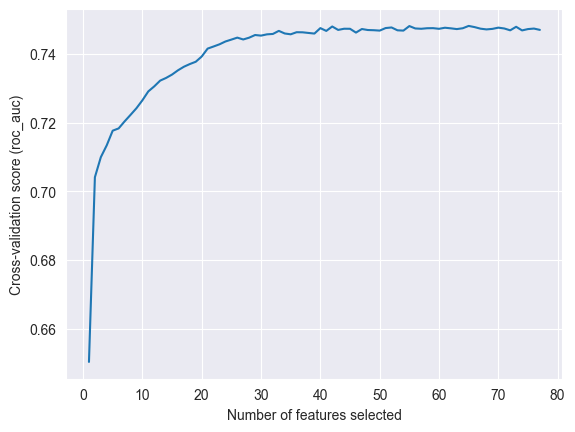

In [397]:
rfecv_xgb = RFECV(estimator=xgb_model, step=1, cv=5, scoring='roc_auc')

rfecv_xgb.fit(X_train_full_preprocessed.values, y_train.values)

print("Optimal number of features: ", rfecv_xgb.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (roc_auc)")
plt.plot(range(1, len(rfecv_xgb.cv_results_['mean_test_score']) + 1), 
         rfecv_xgb.cv_results_['mean_test_score'])
plt.show()

selected_features_xgb = X_train_full_preprocessed.columns[rfecv_xgb.support_]

Optimal number of features (LightGBM):  49


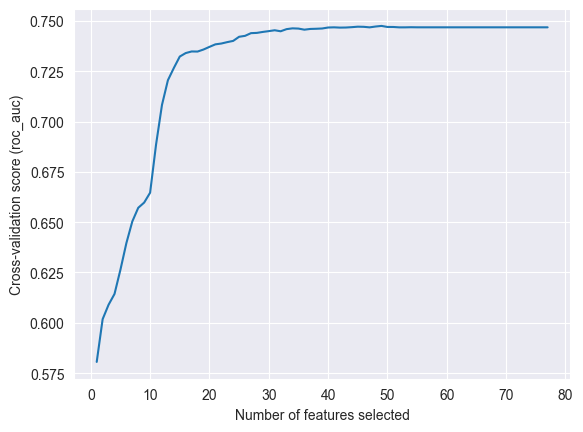

In [393]:
rfecv_lgb = RFECV(estimator=lgb_model, step=1, cv=5, scoring='roc_auc')

rfecv_lgb.fit(X_train_full_preprocessed.values, y_train.values)

print("Optimal number of features (LightGBM): ", rfecv_lgb.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (roc_auc)")
plt.plot(range(1, len(rfecv_lgb.cv_results_['mean_test_score']) + 1), 
         rfecv_lgb.cv_results_['mean_test_score'])
plt.show()

selected_features_lgb = X_train_full_preprocessed.columns[rfecv_lgb.support_]

Optimal number of features (LightGBM):  42


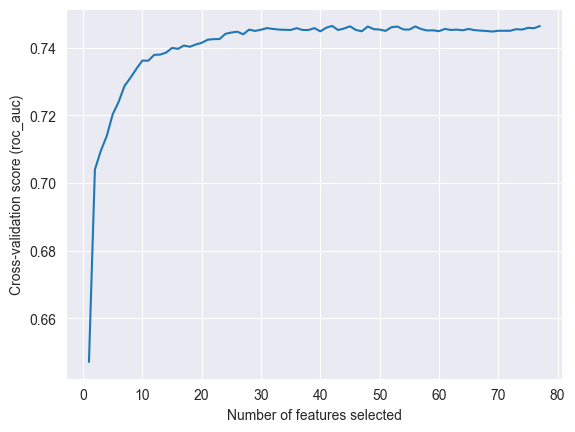

In [395]:
rfecv_catboost = RFECV(estimator=cat_model, step=1, cv=5, scoring='roc_auc')

rfecv_catboost.fit(X_train_full_preprocessed.values, y_train.values)

print("Optimal number of features (LightGBM): ", rfecv_catboost.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (roc_auc)")
plt.plot(range(1, len(rfecv_catboost.cv_results_['mean_test_score']) + 1), 
         rfecv_catboost.cv_results_['mean_test_score'])
plt.show()

selected_features_catboost = X_train_full_preprocessed.columns[rfecv_lgb.support_]

In [402]:
common_features = set(selected_features_xgb) & set(selected_features_lgb) & set(selected_features_catboost)
all_selected_features = list(common_features)
len(all_selected_features)

49

In [403]:
X_train_selected_full = X_train_full_preprocessed[all_selected_features]
X_test_selected_full = X_test_full_preprocessed[all_selected_features]

In [584]:
X_train_selected_full_raw = X_train_full[all_selected_features]
X_test_selected_full_raw = X_test_full[all_selected_features]

cat_features_selected_full = X_train_selected_full_raw.select_dtypes(include='object').columns
float_features_selected_full = X_train_selected_full_raw.select_dtypes(include='float').columns  
int_features_selected_full = X_train_selected_full_raw.select_dtypes(include='int').columns

preprocessor_selected_full = create_preprocessing_pipeline(cat_features_selected_full, 
                                                           float_features_selected_full, 
                                                           int_features_selected_full)
original_selected_full_col_names = cat_features_selected_full.tolist() + float_features_selected_full.tolist() + int_features_selected_full.tolist()

X_train_selected_full_preprocessed = pd.DataFrame(preprocessor_selected_full.fit_transform(X_train_selected_full_raw), 
                                                 columns=original_selected_full_col_names)
X_test_selected_full_preprocessed = pd.DataFrame(preprocessor_selected_full.transform(X_test_selected_full_raw), 
                                                 columns=original_selected_full_col_names)
joblib.dump(preprocessor_selected_full, 'preprocessor_selected_full.joblib')

['preprocessor_selected_full.joblib']

In [460]:
ensemble_model_final = VotingClassifier(estimators=[('xgb', xgb_model), 
                                                    ('cat', cat_model), 
                                                    ('lgb', lgb_model)], 
                                        voting='soft')

ensemble_model_final.fit(X_train_selected_full, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3136251645022881,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=1.2335468130542948,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_...
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=227, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x144dcff10>),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.07343339802009105,
                                             max_depth=5, min_child_samples=52,
                                             n_estimators=185, num_leaves=19,
                                             random_state=42, verbose=-1))],
                 voting='soft')

In [411]:
scores = cross_val_score(ensemble_model_final, 
                         X_train_selected_full.values, 
                         y_train.values, 
                         cv=5, scoring='roc_auc')

mean_score = scores.mean()
std_score = scores.std()

print('Mean CV ROC-AUC score for the ensemble model:', mean_score)
print('CV Standard deviation of ROC-AUC scores for the ensemble model:', std_score)

Mean CV ROC-AUC score for the ensemble model: 0.7500062229542298
CV Standard deviation of ROC-AUC scores for the ensemble model: 0.004692916384364776


In [412]:
ensemble_predictions = ensemble_model_final.predict_proba(X_test_selected_full.values)[:, 1]
y_pred = ensemble_model_final.predict(X_test_selected_full.values) 

ensemble_roc_auc = roc_auc_score(y_test.values, ensemble_predictions)
print('ROC-AUC score for the ensemble model:', ensemble_roc_auc)
f2 = fbeta_score(y_test.values, y_pred, beta=2)
print("F2-score:", f2)
print("Classification Report:\n", classification_report(y_test.values, y_pred, zero_division=1))

ROC-AUC score for the ensemble model: 0.749718604835083
F2-score: 0.6893611959237083
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      4881
           1       0.69      0.69      0.69      5049

    accuracy                           0.69      9930
   macro avg       0.69      0.69      0.69      9930
weighted avg       0.69      0.69      0.69      9930



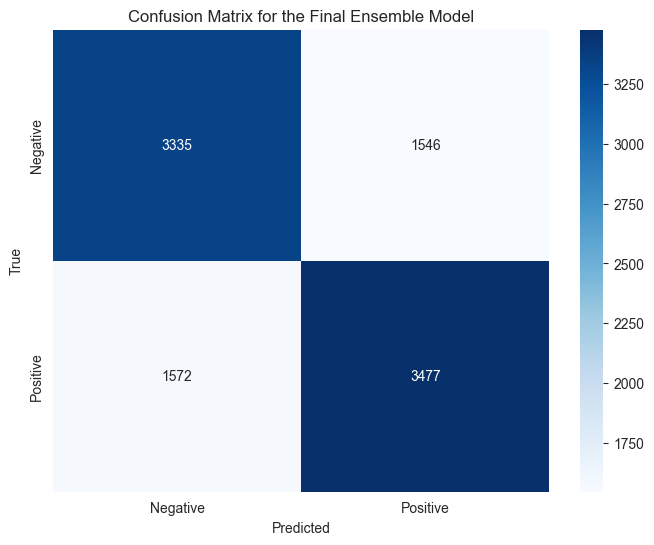

In [417]:
conf_matrix = confusion_matrix(y_test.values, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for the Final Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [534]:
joblib.dump(ensemble_model_final, 'ensemble_model_final.joblib')

['ensemble_model_final.joblib']

## 3.5. Inspecting the models with SHAP and Feature importances

#### Summary: 
- The top-5 most important features by SHAP mean importances among the top-3 models, are:
    - EXT_SOURCE_2
    - EXT_SOURCE_3
    - CODE_GENDER
    - AVG_CREDIT_GOODS_RATIO
    - NUM_PAST_DUE_INSTALL
- The top-5 features in the voting classifier based on aggregated feature importances are:
    -  AGE
    -  AMT_CREDIT
    -  EXT_SOURCE_3
    -  EXT_SOURCE_2
    -  YEARS_EMPLOYED

In [465]:
xgb_model.fit(X_train_selected_full, y_train)  
cat_model.fit(X_train_selected_full, y_train)
lgb_model.fit(X_train_selected_full, y_train)

LGBMClassifier(learning_rate=0.07343339802009105, max_depth=5,
               min_child_samples=52, n_estimators=185, num_leaves=19,
               random_state=42, verbose=-1)

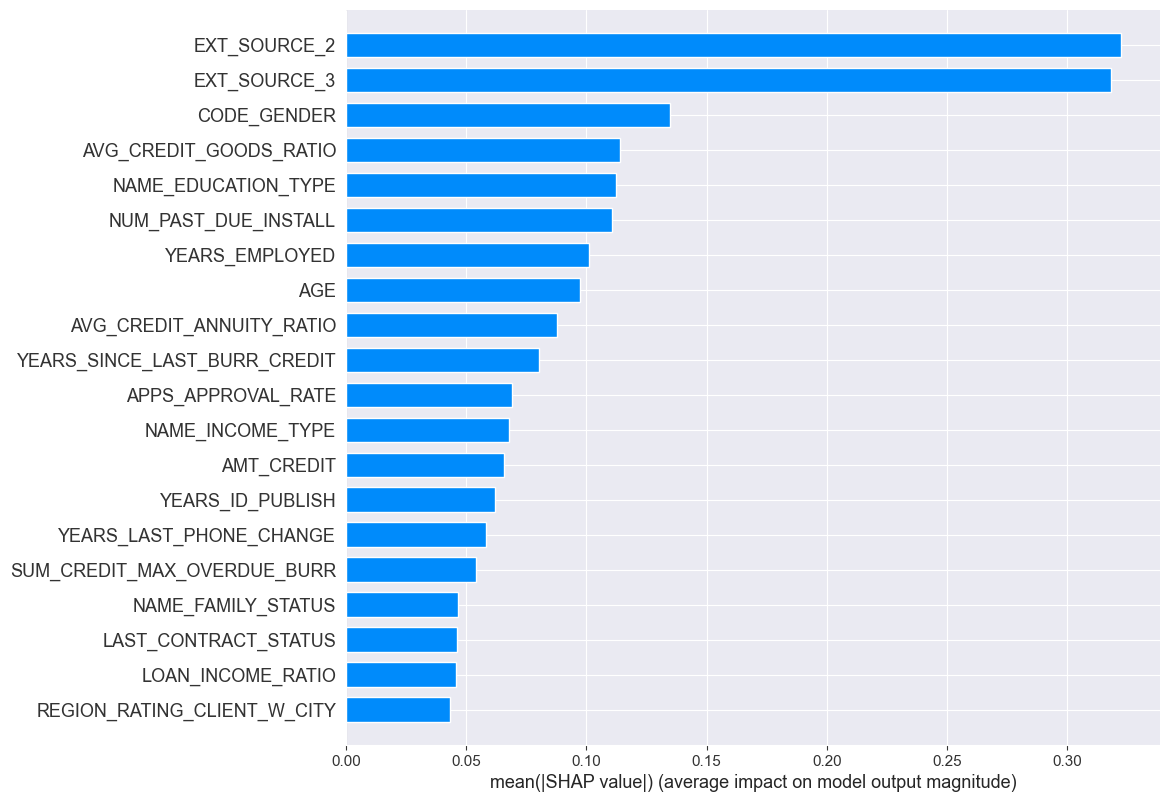

In [529]:
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test_selected_full)
shap.summary_plot(xgb_shap_values, X_test_selected_full, plot_type="bar", show=False)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

In [479]:
shap_sum = np.abs(xgb_shap_values).mean(axis=0)
importance_df_xgb = pd.DataFrame([X_test_selected_full.columns.tolist(), shap_sum.tolist()]).T
importance_df_xgb.columns = ['column_name', 'shap_importance']
importance_df_xgb = importance_df_xgb.sort_values('shap_importance', ascending=False)
importance_df_xgb.head(20)

,column_name,shap_importance
18,EXT_SOURCE_2,0.322385
42,EXT_SOURCE_3,0.31814
16,CODE_GENDER,0.13485
11,AVG_CREDIT_GOODS_RATIO,0.114071
5,NAME_EDUCATION_TYPE,0.112431
4,NUM_PAST_DUE_INSTALL,0.110582
17,YEARS_EMPLOYED,0.101024
14,AGE,0.097303
22,AVG_CREDIT_ANNUITY_RATIO,0.087879
29,YEARS_SINCE_LAST_BURR_CREDIT,0.080258


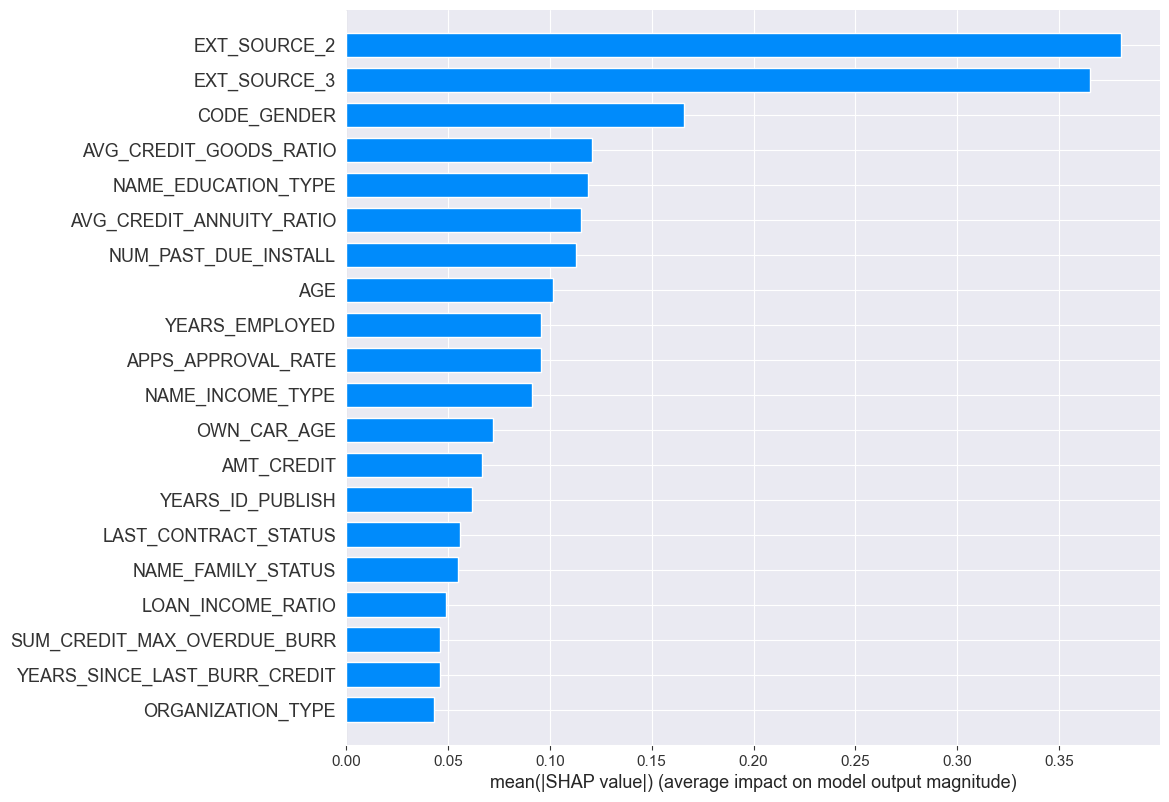

In [480]:
cat_explainer = shap.TreeExplainer(cat_model)
cat_shap_values = cat_explainer.shap_values(X_test_selected_full)
shap.summary_plot(cat_shap_values, X_test_selected_full, plot_type="bar", show=False)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

In [481]:
shap_sum = np.abs(cat_shap_values).mean(axis=0)
importance_df_cat = pd.DataFrame([X_test_selected_full.columns.tolist(), shap_sum.tolist()]).T
importance_df_cat.columns = ['column_name', 'shap_importance']
importance_df_cat = importance_df_cat.sort_values('shap_importance', ascending=False)
importance_df_cat.head(20)

,column_name,shap_importance
18,EXT_SOURCE_2,0.380317
42,EXT_SOURCE_3,0.364946
16,CODE_GENDER,0.165696
11,AVG_CREDIT_GOODS_RATIO,0.120776
5,NAME_EDUCATION_TYPE,0.118811
22,AVG_CREDIT_ANNUITY_RATIO,0.115324
4,NUM_PAST_DUE_INSTALL,0.113115
14,AGE,0.101575
17,YEARS_EMPLOYED,0.095923
38,APPS_APPROVAL_RATE,0.095544


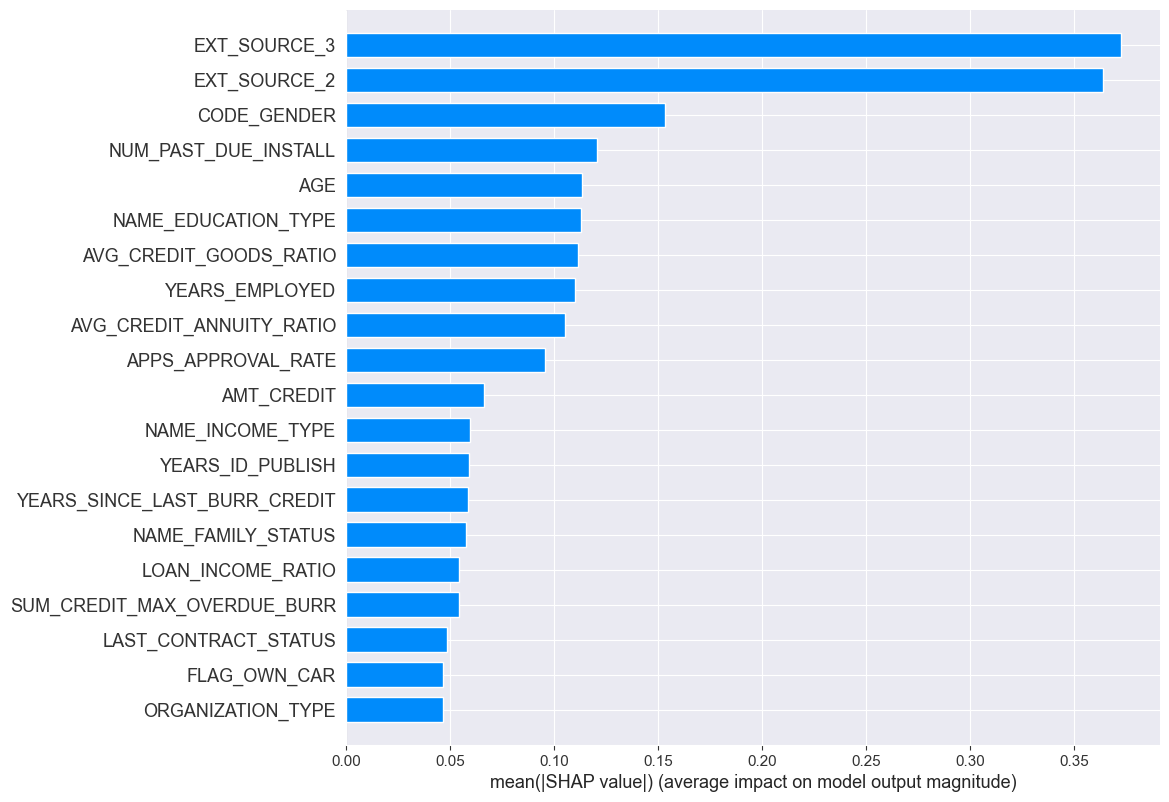

In [528]:
lgb_explainer = shap.TreeExplainer(lgb_model)
lgb_shap_values = lgb_explainer.shap_values(X_test_selected_full)[1]
shap.summary_plot(lgb_shap_values, X_test_selected_full, plot_type="bar", show=False)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

In [503]:
shap_sum = np.abs(lgb_shap_values).mean(axis=0)
importance_df_lgb = pd.DataFrame([X_test_selected_full.columns.tolist(), shap_sum.tolist()]).T
importance_df_lgb.columns = ['column_name', 'shap_importance']
importance_df_lgb = importance_df_lgb.sort_values('shap_importance', ascending=False)
importance_df_lgb.head(20)

,column_name,shap_importance
42,EXT_SOURCE_3,0.372486
18,EXT_SOURCE_2,0.364031
16,CODE_GENDER,0.15339
4,NUM_PAST_DUE_INSTALL,0.120769
14,AGE,0.113491
5,NAME_EDUCATION_TYPE,0.113178
11,AVG_CREDIT_GOODS_RATIO,0.11151
17,YEARS_EMPLOYED,0.110053
22,AVG_CREDIT_ANNUITY_RATIO,0.105433
38,APPS_APPROVAL_RATE,0.095743


In [518]:
merged_top_feat = pd.merge(importance_df_xgb, importance_df_cat, 
                           on='column_name', 
                           suffixes=('_xgb', '_cat'), 
                           how='inner')
merged_top_feats = pd.merge(merged_top_feat, importance_df_lgb, 
                            on='column_name', how='inner')
merged_top_feats.rename(columns={'shap_importance': 'shap_importance_lgb'}, inplace=True)
merged_top_feats['mean_shap_importance'] = merged_top_feats[['shap_importance_xgb', 
                                                             'shap_importance_cat', 
                                                             'shap_importance_lgb']].mean(axis=1)

merged_top_feats_df = merged_top_feats[['column_name', 'mean_shap_importance']]
merged_top_feats_df = merged_top_feats_df.sort_values(by='mean_shap_importance', 
                                                      ascending=False)
merged_top_feats_df.head(10)

,column_name,mean_shap_importance
0,EXT_SOURCE_2,0.355578
1,EXT_SOURCE_3,0.351857
2,CODE_GENDER,0.151312
3,AVG_CREDIT_GOODS_RATIO,0.115452
5,NUM_PAST_DUE_INSTALL,0.114822
4,NAME_EDUCATION_TYPE,0.114807
7,AGE,0.104123
8,AVG_CREDIT_ANNUITY_RATIO,0.102879
6,YEARS_EMPLOYED,0.102334
10,APPS_APPROVAL_RATE,0.086787


- The top-5 most important features by SHAP mean importances among the top-3 models, are:
    -  EXT_SOURCE_2
    -  EXT_SOURCE_3
    -  CODE_GENDER
    -  AVG_CREDIT_GOODS_RATIO
    -  NUM_PAST_DUE_INSTALL

##### Computing feature importances for the Ensemble model

In [522]:
def compute_feature_importance(voting_clf):
    """ 
    Function to compute aggregated 
    feature importance of a Voting Classifier.
    """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        fe_scores = list(np.add(fe_scores, list(imp_score)))
    return fe_scores

In [523]:
vc_feats = pd.DataFrame()
vc_feats['Feature'] = X_train_selected_full.columns
vc_feats['Feature Importance'] = compute_feature_importance(ensemble_model_final)
vc_feats.sort_values('Feature Importance', ascending=False).head(10)

,Feature,Feature Importance
14,AGE,198.348435
37,AMT_CREDIT,177.825608
42,EXT_SOURCE_3,165.210797
18,EXT_SOURCE_2,152.203885
17,YEARS_EMPLOYED,138.323937
22,AVG_CREDIT_ANNUITY_RATIO,133.995935
4,NUM_PAST_DUE_INSTALL,124.825714
0,LOAN_INCOME_RATIO,123.396255
32,YEARS_ID_PUBLISH,116.835324
31,ORGANIZATION_TYPE,112.352140


- The top-5 features in the voting classifier based on aggregated feature importances are:
    -  AGE
    -  AMT_CREDIT
    -  EXT_SOURCE_3
    -  EXT_SOURCE_2
    -  YEARS_EMPLOYED

# 4. Deploying the ML model

- The code for the deployment is in the folder homecredit_app.
- The app link: https://home-credit-loan-prediction.uc.r.appspot.com/

# 5. Building and testing a deep neural network-based model

In [609]:
def roc_auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred) 

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train_selected_full.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',  
              metrics=[AUC(curve='ROC', name='roc_auc')])

model.fit(X_train_selected_full, y_train, 
          epochs=100, 
          batch_size=64,
          validation_data=(X_test_selected_full, y_test))

Epoch 1/100
621/621 [==============================] - 2s 2ms/step - loss: 0.7352 - roc_auc: 0.5515 - val_loss: 0.6554 - val_roc_auc: 0.6996
Epoch 2/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6492 - roc_auc: 0.6703 - val_loss: 0.6254 - val_roc_auc: 0.7233
Epoch 3/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6326 - roc_auc: 0.6991 - val_loss: 0.6164 - val_roc_auc: 0.7277
Epoch 4/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6276 - roc_auc: 0.7073 - val_loss: 0.6130 - val_roc_auc: 0.7297
Epoch 5/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6246 - roc_auc: 0.7118 - val_loss: 0.6152 - val_roc_auc: 0.7306
Epoch 6/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6222 - roc_auc: 0.7143 - val_loss: 0.6165 - val_roc_auc: 0.7308
Epoch 7/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6184 - roc_auc: 0.7192 - val_loss: 0.6210 - val_roc_auc: 0.7320
Epoch 8/100
6

In [615]:
model_full = Sequential()
model_full.add(Dense(32, activation='relu', input_shape=(X_train_full_preprocessed.shape[1],)))
model_full.add(Dropout(0.5))
model_full.add(Dense(16, activation='relu')) 
model_full.add(Dropout(0.3))
model_full.add(Dense(1, activation='sigmoid'))

model_full.compile(loss='binary_crossentropy',
              optimizer='adam',  
              metrics=[AUC(curve='ROC', name='roc_auc')])

model_full.fit(X_train_full_preprocessed, y_train, 
               epochs=100, 
               batch_size=64,
               validation_data=(X_test_full_preprocessed, y_test))

Epoch 1/100
621/621 [==============================] - 2s 2ms/step - loss: 0.6891 - roc_auc: 0.5943 - val_loss: 0.6354 - val_roc_auc: 0.7164
Epoch 2/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6424 - roc_auc: 0.6839 - val_loss: 0.6191 - val_roc_auc: 0.7279
Epoch 3/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6302 - roc_auc: 0.7037 - val_loss: 0.6145 - val_roc_auc: 0.7310
Epoch 4/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6249 - roc_auc: 0.7121 - val_loss: 0.6112 - val_roc_auc: 0.7319
Epoch 5/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6223 - roc_auc: 0.7155 - val_loss: 0.6093 - val_roc_auc: 0.7335
Epoch 6/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6203 - roc_auc: 0.7168 - val_loss: 0.6098 - val_roc_auc: 0.7339
Epoch 7/100
621/621 [==============================] - 1s 1ms/step - loss: 0.6170 - roc_auc: 0.7221 - val_loss: 0.6061 - val_roc_auc: 0.7346
Epoch 8/100
6

In [616]:
probs = model.predict(X_test_selected_full)
y_pred = np.round(probs)

_, auc_score = model.evaluate(X_test_selected_full, y_test)
print(f'ROC-AUC Score (selected features): {auc_score}')

f2 = fbeta_score(y_test, y_pred, beta=2)
print('F2 Score (selected features): {}'.format(f2))

311/311 [==============================] - 0s 818us/step - loss: 0.6077 - roc_auc: 0.7388
ROC-AUC Score (selected features): 0.7387585639953613
F2 Score (selected features): 0.6799507799785656


In [618]:
probs_full = model_full.predict(X_test_full_preprocessed)
y_pred_full = np.round(probs_full)

_, auc_score = model_full.evaluate(X_test_full_preprocessed, y_test)
print(f'ROC-AUC Score (all features): {auc_score}')

f2 = fbeta_score(y_test, y_pred_full, beta=2)
print('F2 Score (all features): {}'.format(f2))

311/311 [==============================] - 0s 828us/step - loss: 0.6029 - roc_auc: 0.7414
ROC-AUC Score (all features): 0.7413886785507202
F2 Score (all features): 0.6724234428719917


- The unoptimized deep NN model gives a bit lower result than the final ensembled voting classifier (on selected features).

# 6. Conclusions and further improvement

#### Main insights and observations: 
- Based on initial tuning with Bayesian Optimization, the top-3 algorithms based on ROC-AUC score are:
    - XGBoost (0.7404)
    - CatBoost (0.7391)
    - LightGBM (0.7384)
- The best ensemble model's ROC-AUC score is: 0.74948. This result is higher than for individual optimized models.
- Reducing the number of features to 49 results in a higher ROC-AUC score: 0.7497.
- The top-5 most important features by SHAP mean importances among the top-3 models, are:
    - EXT_SOURCE_2
    - EXT_SOURCE_3
    - CODE_GENDER
    - AVG_CREDIT_GOODS_RATIO
    - NUM_PAST_DUE_INSTALL
- The top-5 features in the voting classifier based on aggregated feature importances are:
    -  AGE
    -  AMT_CREDIT
    -  EXT_SOURCE_3
    -  EXT_SOURCE_2
    -  YEARS_EMPLOYED
- The unoptimized deep NN model gives a bit lower result than the final ensembled voting classifier (on selected features).

#### Recommendations: 
- The final metric should be discussed with the client beforehand. We need to discuss the cost of an application review and possible losses in case of False negatives (problematic loan flagged as a non-problematic one), and based on this information we should select an appropriate performance metric to optimize our model.
- The model was optimized to maximize ROC-AUC score (the capability of distinguishing between positive and negative classes). Though our final model's ROC-AUC score is fairly okay (0.75), it's far from perfect and Home Credit employees should make final decisions using their own expertise.

#### Further improvement: 
- The results of the model can and should be improved. So far, we got 0.75 ROC-AUC score, so there's a lot of room for improvement. We could try different feature engineering and encoding techniques, and/or try out other ML algorithms to get a better result.
- It would be helpful to add feature importance scores printed out at the prediction page of the Flask app, so that the employee could better understand the prediction.